# **Task 2**

could also be found at:
https://colab.research.google.com/drive/1qZx_6MOuTyAsl5_8ubqhqz0Vn44BOMmG?usp=sharing

## Imports and helper functions

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
import time
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
!pip install kafka-python
import time
from kafka import KafkaConsumer
from numpy import nan
from numpy import inf
import ast
import pickle
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 11.7,8.27
rcParams.update({'font.size': 22})

In [ ]:
''' This function trains and tests the model using the training and testing sets. it returns the predictions, F1 score and classification report '''
def train_test_clf(model, X_train, X_test, y_train, y_test,labels):
    print('Start training....', end='')
    model.fit(X_train, y_train)
    print('done!')
    print('Start testing....', end='')
    predictions = model.predict(X_test)
    f1score = metrics.f1_score(y_test, predictions, average="weighted")
    metrics_report = classification_report(y_test, predictions, target_names=labels)
    precision, recall, fscore, train_support = score(y_test, predictions, average='weighted')
    print('done!')
    return predictions, f1score, metrics_report, (precision, recall, fscore)

In [ ]:
'''
This function contains a loop that is called within the dynamic solution, responsible for pulling the data from the dynamic source,
iterating through them, and preprocessing them accordingly. After that, the function is also responsible for appending the pulled packets to the 
dataset for further prediction.
The function takes the number of packets in the sliding window (10K packets in this case), and returns a dataframe representing the dataset ready for prediction.
'''
def consumer_loop(iterations):
  df= pd.DataFrame()
  i = 0
  arr = []
  for message in consumer:
      # print(f"Consuming the {i+1}th data packet!")
      data_packet=message.value
      # data_packet = data_packet.decode("utf-8")
      # data_packet = data_packet.replace('inf', 'inf')
      # data_packet = data_packet.replace('-inf', 'inf * -1)')
      # data_packet = data_packet.replace('nan', 'np.nan')
      x = eval(data_packet)
      arr.append(x)
      if i == iterations-1:
          break
      i += 1

  df = df.append(arr,ignore_index=True)
  # df.columns = df.columns.str.replace(' ', '')
  # df = df[df.columns]
  df = df.drop(['Source'], axis=1)
  df['Class'] = enc.transform(df['Class'])
  # df = data_clean(df)  
  # df[df.columns[:-1]] = rs.transform(df[df.columns[:-1]])
  return df 

## Loading dataset

In [ ]:
'''
Loading the dataset from a private repo in my own github account, (Note: the repository is private. It is only used for storage. the given dataset is not shared anywhere 
on the internet whatsoever) to avoid uploading the dataset into google colab runtime session each time the runtime is recycled.
'''
data = pd.read_csv('https://raw.githubusercontent.com/NourhanWagdi/Kafka/main/iot_static_data.csv?token=AJY3Q3Y7E4J5YKSVFHMLRPTBT2J7C')
data.head(3)

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,MI_dir_L0.1_mean,MI_dir_L0.1_variance,MI_dir_L0.01_weight,MI_dir_L0.01_mean,MI_dir_L0.01_variance,H_L5_weight,H_L5_mean,H_L5_variance,H_L3_weight,H_L3_mean,H_L3_variance,H_L1_weight,H_L1_mean,H_L1_variance,H_L0.1_weight,H_L0.1_mean,H_L0.1_variance,H_L0.01_weight,H_L0.01_mean,H_L0.01_variance,HH_L5_weight,HH_L5_mean,HH_L5_std,HH_L5_magnitude,HH_L5_radius,HH_L5_covariance,HH_L5_pcc,HH_L3_weight,HH_L3_mean,HH_L3_std,...,HH_jit_L0.01_weight,HH_jit_L0.01_mean,HH_jit_L0.01_variance,HpHp_L5_weight,HpHp_L5_mean,HpHp_L5_std,HpHp_L5_magnitude,HpHp_L5_radius,HpHp_L5_covariance,HpHp_L5_pcc,HpHp_L3_weight,HpHp_L3_mean,HpHp_L3_std,HpHp_L3_magnitude,HpHp_L3_radius,HpHp_L3_covariance,HpHp_L3_pcc,HpHp_L1_weight,HpHp_L1_mean,HpHp_L1_std,HpHp_L1_magnitude,HpHp_L1_radius,HpHp_L1_covariance,HpHp_L1_pcc,HpHp_L0.1_weight,HpHp_L0.1_mean,HpHp_L0.1_std,HpHp_L0.1_magnitude,HpHp_L0.1_radius,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,Source,Class
0,19.570634,152.679121,39991.937640,20.937891,150.455024,38960.674060,23.168006,145.454142,36954.21504,33.115077,123.515434,27655.53889,62.619034,102.471926,15409.86815,19.570634,152.679121,39991.937640,20.937891,150.455024,38960.674060,23.168006,145.454142,36954.21504,33.115077,123.515434,27655.53889,62.619034,102.471926,15409.86815,18.885473,156.041505,202.780449,349.823034,160261.014500,-29563.398800,-0.370432,20.044037,154.488822,200.790831,...,30.034811,5.307252,129.851752,4.880738,181.620841,227.548005,291.835506,59579.844560,17447.876,0.446623,4.927844,181.698241,227.581665,291.280119,59578.905890,17793.81865,0.455634,4.975746,181.767997,227.609424,290.719232,59575.027260,18141.80757,0.464725,4.997565,181.796886,227.619989,290.465036,59572.320380,18299.05366,0.468843,4.999756,181.799689,227.620979,290.439555,59572.01682,18314.80015,0.469256,Provision PT 838 Security Camera,BENIGN
1,49.893840,169.297843,54532.338720,62.957476,169.735104,54283.995040,82.340884,168.919514,53449.81973,98.214224,164.300338,51038.67281,124.460107,146.697496,42083.22328,49.893840,169.297843,54532.338720,62.957476,169.735104,54283.995040,82.340884,168.919514,53449.81973,98.214224,164.300338,51038.67281,124.460107,146.697496,42083.22328,49.886530,169.313860,233.534964,295.273638,90407.873240,-2457.802895,-0.039193,62.898830,169.837418,233.073744,...,97.549007,1.686998,63.199293,1.980432,69.960478,3.999805,101.835497,15.998438,0.000,0.000000,1.988213,69.976286,3.999930,101.846358,15.999438,0.00000,0.000000,1.996055,69.992095,3.999992,101.857221,15.999938,0.00000,0.000000,1.999605,69.999210,4.000000,101.862109,15.999999,0.00000,0.000000,1.999960,69.999921,4.000000,101.862598,16.00000,0.00000,0.000000,Provision PT 737E Security Camera,BENIGN
2,1.996527,449.011775,409.365474,2.002395,448.141152,739.076602,2.166552,419.128740,11039.48506,4.621621,278.780846,34237.68791,29.401508,286.241737,32040.66862,1.996527,449.011775,409.365474,2.002395,448.141152,739.076602,2.166552,419.128740,11039.48506,4.621621,278.780846,34237.68791,29.401508,286.241737,32040.66862,1.996402,449.036043,19.999968,449.036043,399.998701,0.000000,0.000000,1.997840,449.021626,19.999988,...,14.978833,10.667405,206.157032,1.996402,449.036043,19.999968,449.036043,399.998701,0.000,0.000000,1.997840,449.021626,19.999988,449.021626,399.999532,0.00000,0.000000,1.999279,449.007209,19.999999,449.007209,399.999948,0.00000,0.000000,2.428558,450.295009,20.081460,450.295009,403.265056,0.00000,0.000000,14.978833,455.354366,19.592951,455.354366,383.88371,0.00000,0.000000,Samsung SNH 1011 N Webcam,BENIGN


## Data preprocessing

In [ ]:
labels = data['Class'].unique()

In [ ]:
'''
Encoding the label into a numeric form so it would be machine-readable
'''
enc = LabelEncoder()
data['Class'] = enc.fit_transform(data['Class'])

In [ ]:
'''
Dropped the Source column as it only contains string values that cannot be handled by any of the models
'''
data = data.drop(['Source'], axis=1)

In [ ]:
'''
Separated labels from the rest of the features
'''
X = data.drop(['Class'], axis=1)
y = data['Class']
y.head(5)

0    0
1    0
2    0
3    0
4    9
Name: Class, dtype: int64

### Data balancing

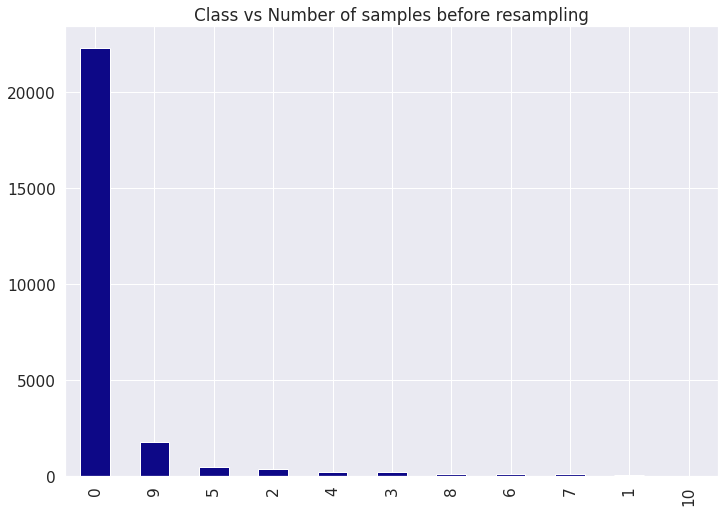

In [ ]:
'''
plotting a bar graph that shows the count of samples for each class (huge imbalance observed)
'''
before_res = y.value_counts().plot(kind='bar', title='Class vs Number of samples before resampling', cmap='plasma')
plt.show()

In [ ]:
'''
Resampling in attempt to balance the dataset.
The class with the highest number of samples was undersampled, while the classes with relatively low number of samples were oversampled.
'''
print('Original dataset shape %s' % Counter(y))
count_class_0 = 8000
count_class_9 = 5000
count_class_5 = 1500
count_class_2 = 600
count_class_4 = 500
count_class_3 = 300
count_class_8 = 300
count_class_6 = 200
count_class_7 = 200
count_class_1 = 200
count_class_10 = 100

pipe = make_pipeline(          # a pipeline was created to assemble the steps of resampling together (SMOTE for oversampling, and NearMiss for undersampling) 
    SMOTE(sampling_strategy={9: count_class_9, 5: count_class_5, 2: count_class_2, 4: count_class_4,
                             3: count_class_3, 8: count_class_8, 6: count_class_6, 7: count_class_7,
                             1: count_class_1, 10: count_class_10,}),
    NearMiss(sampling_strategy={0: count_class_0})
)

X, y = pipe.fit_resample(X, y)

print('Resampled dataset shape %s' % Counter(y))

Original dataset shape Counter({0: 22287, 9: 1774, 5: 446, 2: 377, 4: 213, 3: 200, 8: 101, 6: 96, 7: 86, 1: 18, 10: 11})
Resampled dataset shape Counter({0: 8000, 9: 5000, 5: 1500, 2: 600, 4: 500, 3: 300, 8: 300, 1: 200, 6: 200, 7: 200, 10: 100})


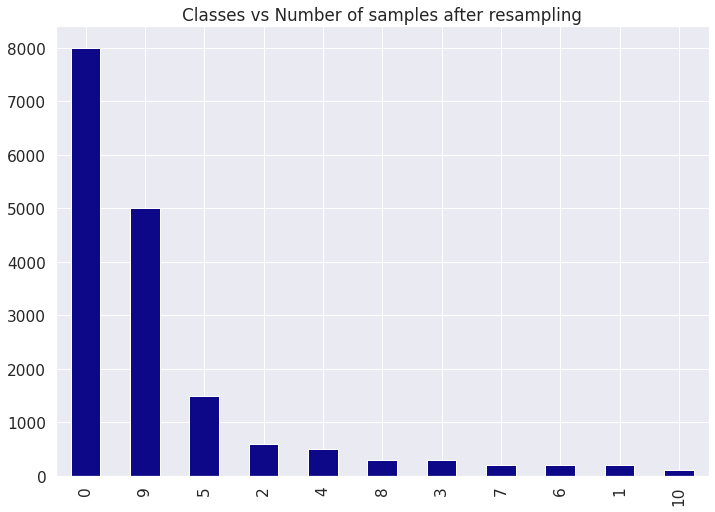

In [ ]:
'''
bar graph was plotted again to show the count of samples for each class after resampling.
(Note: resampling was done carefully and flattening the bars was avoided not to overwhelm the classifiers with too many false positives.)
'''
after_res = y.value_counts().plot(kind='bar', title='Classes vs Number of samples after resampling', cmap='plasma')
plt.show()

### Data splitting

In [ ]:
'''
Splitting the data into training and testing portions using 60% for training and 40% for testing.
'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
print('Training set Shape: {}  | Test set Shape: {}'.format(X_train.shape, X_test.shape))

Training set Shape: (10140, 115)  | Test set Shape: (6760, 115)


##First learning algorithm (Static) - Decision tree

In [ ]:
'''
Decision tree classifier is defined, all hyperparameters remained default.
'''
DT_model = DecisionTreeClassifier()
predictions, f1score, metrics_report, DT_prf = train_test_clf(DT_model, X_train, X_test, y_train, y_test, labels)

Start training....done!
Start testing....done!


In [ ]:
'''
In the following two cells, predictions are made and a classification report with all the findings is shown.
'''
y_pred1 = DT_model.predict(X_test)

In [ ]:
print('F1 score: {}'.format(f1score))
print('='*100)
print(metrics_report)

F1 score: 0.9989644186153007
                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00      3187
     mirai_udp_attack       0.97      0.97      0.97        71
     mirai_ack_attack       0.99      0.99      0.99       257
   gafgyt_scan_attack       0.99      1.00      1.00       117
    mirai_scan_attack       1.00      0.99      1.00       183
    gafgyt_tcp_attack       1.00      1.00      1.00       594
    gafgyt_udp_attack       1.00      0.99      0.99        87
   gafgyt_junk_attack       1.00      1.00      1.00        85
  gafgyt_combo_attack       1.00      1.00      1.00       116
     mirai_syn_attack       1.00      1.00      1.00      2022
mirai_udpplain_attack       1.00      1.00      1.00        41

             accuracy                           1.00      6760
            macro avg       1.00      1.00      1.00      6760
         weighted avg       1.00      1.00      1.00      6760



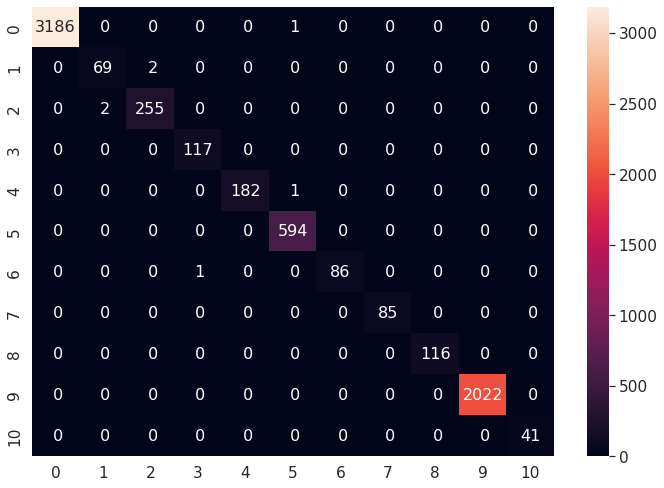

In [ ]:
'''
The below code is responsible for showing the confusion matrix for the model, in which the numbers of correct and incorrect predictions are summarized in the form
of a heatmap using seaborn.
'''
cm_DT = metrics.confusion_matrix(y_test,y_pred1)
sns.set(font_scale=1.4)
sns.heatmap(cm_DT, annot=True, annot_kws={"size": 16}, fmt='2g')
plt.show()

##Second learning algorithm (Static) - Random forest

In [ ]:
'''
Random forest classifier is defined, all hyperparameters remained default.
'''
RF_model = RandomForestClassifier()
predictions, f1score, metrics_report, RF_prf = train_test_clf(RF_model, X_train, X_test, y_train, y_test, labels)

Start training....done!
Start testing....done!


In [ ]:
'''
In the following two cells, predictions are made and a classification report with all the findings is shown.
'''
y_pred2 = RF_model.predict(X_test)

In [ ]:
print('F1 score: {}'.format(f1score))
print('='*100)
print(metrics_report)

F1 score: 0.999851930570774
                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00      3187
     mirai_udp_attack       1.00      1.00      1.00        71
     mirai_ack_attack       1.00      1.00      1.00       257
   gafgyt_scan_attack       1.00      1.00      1.00       117
    mirai_scan_attack       1.00      0.99      1.00       183
    gafgyt_tcp_attack       1.00      1.00      1.00       594
    gafgyt_udp_attack       1.00      1.00      1.00        87
   gafgyt_junk_attack       1.00      1.00      1.00        85
  gafgyt_combo_attack       1.00      1.00      1.00       116
     mirai_syn_attack       1.00      1.00      1.00      2022
mirai_udpplain_attack       1.00      1.00      1.00        41

             accuracy                           1.00      6760
            macro avg       1.00      1.00      1.00      6760
         weighted avg       1.00      1.00      1.00      6760



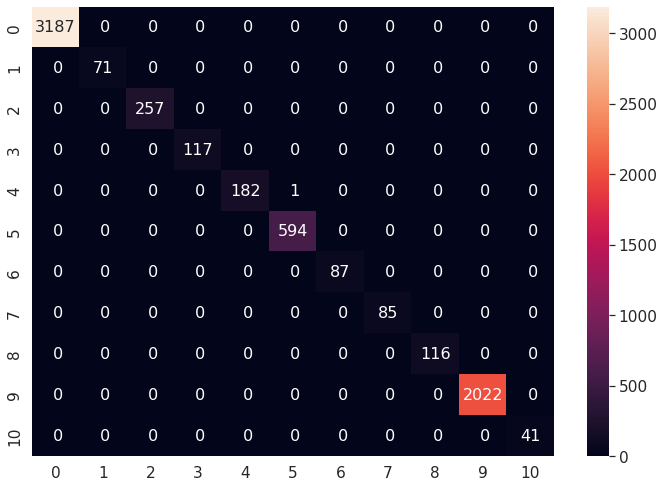

In [ ]:
'''
The below code is responsible for showing the confusion matrix for the model, in which the numbers of correct and incorrect predictions are summarized in the form
of a heatmap using seaborn.
'''
cm_RF = metrics.confusion_matrix(y_test,y_pred2)
sns.set(font_scale=1.4)
sns.heatmap(cm_RF, annot=True, annot_kws={"size": 16}, fmt='2g')
plt.show()

## Dynamic model (adapts through time)

In [ ]:
consumer = KafkaConsumer(
    'task2',
    bootstrap_servers="34.130.121.39:9092",
    sasl_plain_username="student",
    sasl_plain_password="uottawa",
    security_protocol="SASL_PLAINTEXT",
    sasl_mechanism="PLAIN",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

In [ ]:
with open('classifier', 'wb') as file1:
    pickle.dump(RF_model, file1)
with open('classifier' , 'rb') as file2:
    stat = pickle.load(file2)
with open('classifier' , 'rb') as file3:
    dyn = pickle.load(file3)

In [ ]:
dyn_data = data
PACKET_MAX = 100000
sliding_window = 10000
steps = PACKET_MAX // sliding_window
all_scores_stat = []
all_scores_dyn = []
data = []
data = pd.DataFrame()

for n in range(steps):          #for loop that takes number of iterations (10 iterations since the batch size is 10K)
  
  #calling the consumer_loop function to pull and preprocess the data packets from the Kafka server
  df_consumer = consumer_loop(sliding_window)
  
  #separating labels from the rest of the features
  X_dyn = dyn_data.drop(['Class'], axis=1)
  y_dyn = dyn_data['Class']

  #predictions are made for further evaluation. Then, f-1 scores are printed for each iteration
  y_pred_dyn = dyn.predict(X_dyn)
  y_pred_stat = stat.predict(X_dyn)
  f1_iter_dyn = metrics.f1_score(y_dyn, y_pred_dyn, average="weighted")
  f1_iter_stat = metrics.f1_score(y_dyn, y_pred_stat, average= "weighted")

  all_scores_dyn.append(f1_iter_dyn)
  all_scores_stat.append(f1_iter_stat)
  
  #this line of code deletes 10K rows from the dataset
  dyn_data = dyn_data.iloc[sliding_window: , :]

  #while this line appends the new data (10K) pulled from the Kafka server to the dataset
  dyn_data = dyn_data.append(df_consumer)

  #creating new X and y ready to be fit into the model
  X_dyn_new = dyn_data.drop(['Class'], axis=1)
  y_dyn_new = dyn_data['Class']

  #the chosen model here was the random forest as it provided a slightly better performance
  dyn.fit(X_dyn_new,y_dyn_new)

In [ ]:
print(all_scores_stat)
print(all_scores_dyn)

[0.9976124885814011, 0.9973810601805764, 0.9973779854584369, 0.9973186631097424, 0.9972833411358597, 0.9969710141541196, 0.996701613487084, 0.9970634079816405, 0.9973932845193428, 0.9974233683771199]
[0.9976124885814011, 0.9998041825701537, 0.9998042541604889, 0.9997649479719569, 0.9997649880447499, 0.9998434745113142, 0.9997649824677709, 0.9997647905712497, 0.9998041948550163, 0.9998826974268102]


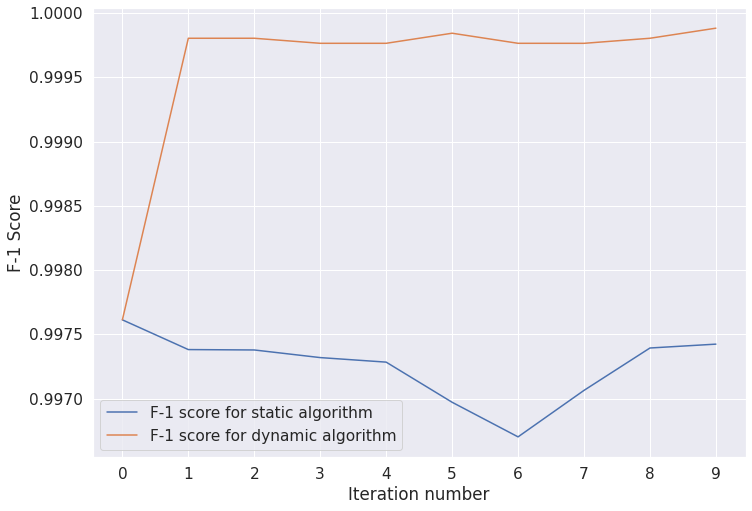

In [ ]:
plt.plot(all_scores_stat)
plt.plot(all_scores_dyn)
plt.xlabel('Iteration number')
plt.ylabel('F-1 Score')
plt.xticks(range(0,10))
plt.legend(['F-1 score for static algorithm','F-1 score for dynamic algorithm'])
plt.show()